In [1]:
%load_ext autoreload
%autoreload 2

import torch
import tqdm
import numpy as np
from ase import io
import matplotlib.pyplot as plt


import sys
sys.path.append("../../fande") # Adds higher directory to python modules path.
sys.path.append("..") # Adds higher directory to python modules path.

print(os.getcwd())

/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks


### Parsing and loading data:

In [2]:
from sdynamics.load import parse_trajectories, parse_forces, flatten_trj_dictionaries

#Load and parse trajectories:
trajectories, energies_trj, trj_files_basenames = parse_trajectories(traj_folder="../data/dynamics/ene_grad_fitting/data/trj/")
forces_trj = parse_forces(forces_path = '../data/dynamics/ene_grad_fitting/data/grad/', trj_files_basenames = trj_files_basenames)

#Flatten all into a single trajectory:
traj, energies, forces = flatten_trj_dictionaries(trajectories, energies_trj, trj_files_basenames, forces_trj)

Reading trajectory files...


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

Trajectory files reading done!
Reading .npy files with forces...
Reading .npy files with forces done!
Flattening done!


### Prepare training/test datasets:

#### Usual xtb MD

In [50]:
# XTB normal MD
from ase.visualize import view

traj_xtb_md = io.read("../data/dump/xtb_md/asemd.traj", index=":")
forces_xtb_md = np.load("../data/dump/xtb_md/forces_xtb_md.npy")
energies_xtb_md = np.load("../data/dump/xtb_md/energies_xtb_md.npy")

# Training data:
# training_indices = np.sort(  np.random.choice(np.arange(0,10_000), 1000, replace=False) )
training_indices = np.sort(  np.arange(0, 9_000, 10) )  
traj_train = [traj_xtb_md[i] for i in training_indices]
energies_train = energies_xtb_md[training_indices]
forces_train = forces_xtb_md[training_indices]
train_data = {'trajectory': traj_train, 'energies': energies_train, 'forces': forces_train}

#Test data:
# test_indices = np.sort(  np.random.choice(np.arange(0,92795), 200, replace=False) ) 
test_indices = np.sort(  np.arange(9_000,9_101,2) ) 
traj_test = [traj_xtb_md[i] for i in test_indices]
energies_test = energies_xtb_md[test_indices]
forces_test = forces_xtb_md[test_indices]
test_data = {'trajectory': traj_test, 'energies': energies_test, 'forces': forces_test}

data_units = "ev_angstrom" # standard ase units

#### Saddle point MD

In [36]:
# # Training data:
# # training_indices = np.sort(  np.random.choice(np.arange(0,10_000), 1000, replace=False) )
# training_indices = np.sort(  np.arange(0, 90000, 200) )  
# traj_train = [traj[i] for i in training_indices]
# energies_train = energies[training_indices]
# forces_train = forces[training_indices]
# train_data = {'trajectory': traj_train, 'energies': energies_train, 'forces': forces_train}

# #Test data:
# # test_indices = np.sort(  np.random.choice(np.arange(0,92795), 200, replace=False) ) 
# test_indices = np.sort(  np.arange(1,101,2) ) 
# traj_test = [traj[i] for i in test_indices]
# energies_test = energies[test_indices]
# forces_test = forces[test_indices]
# test_data = {'trajectory': traj_test, 'energies': energies_test, 'forces': forces_test}

# data_units = "hartree_bohr"

#### Data initialization and descriptors computations

(900, 17, 3)


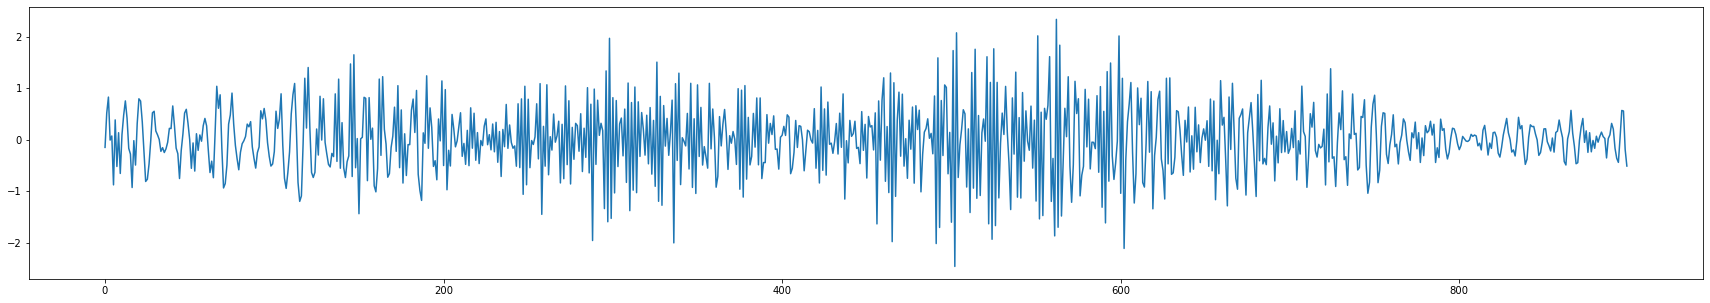

In [51]:
from fande.data import FandeDataModuleASE

hparams = {
    'dtype' : 'float64',
    'device' : 'gpu'
}

fdm = FandeDataModuleASE(train_data, test_data, hparams, units=data_units)

print(fdm.forces_train_norm.shape)
plt.plot(fdm.forces_train[:,16,0])

In [52]:
soap_params = {
    'species': ["H", "C"],
    'periodic': False,
    'rcut': 3.0,
    'sigma': 0.5,
    'nmax': 5,
    'lmax': 5,
    'average': "outer",
    'crossover': True,
    'dtype': "float64",
    'n_jobs': 10,
    'sparse': False,
    'positions': [0,2,3,6]
}

fdm.calculate_invariants(soap_params)

print(fdm.train_DX.shape)

Total length of train traj is 900
Starting SOAP calculation...
SOAP calculation done!
Total length of test traj is 51
Starting SOAP calculation...
SOAP calculation done!
(900, 17, 3, 330)
(900, 330)
torch.Size([45900, 330])


### Fitting Forces:

In [53]:
from fande.models import ModelForces, ModelEnergies, MyCallbacks
from torch.utils.data import DataLoader, TensorDataset, random_split
from pytorch_lightning import Trainer, seed_everything
import numpy as np
# seed_everything(42, workers=True)

train_DX = fdm.train_DX
train_F = fdm.train_F
test_DX = fdm.test_DX
test_F = fdm.test_F

# ind_slice = np.sort( np.concatenate( 
#     ( np.arange(0,4800), np.arange(11*4800,12*4800), np.random.choice(np.arange(4800,59200), 300, replace=False) ) 
#     ) )

ind_slice = np.sort(  np.random.choice(np.arange(0,train_F.shape[0]), 10_000, replace=False) ) 
# ind_slice = np.sort(  np.arange(0,2550) ) 
# ind_slice = np.sort(  np.arange(0,train_F.shape[0]) ) 


train_dataset = TensorDataset(train_DX[ind_slice], train_F[ind_slice])
train_loader = DataLoader(train_dataset, batch_size=100_000)

model_f = ModelForces(train_DX[ind_slice], train_F[ind_slice], hparams, 0.05)

trainer_f = Trainer(
    gpus=1, 
    max_epochs=100, 
    precision=64,
    weights_summary='full', 
    callbacks=[MyCallbacks()])

trainer_f.fit(model_f, train_loader)

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:187: LightningDeprecationWarning:

Setting `Trainer(weights_summary=full)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.model_summary.ModelSummary` with `max_depth` directly to the Trainer's `callbacks` argument instead.

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:394: UserWarning:

The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for lo


 setup() callback called...
Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, loss=-0.317, v_num=205] 

 teardown() callback called...


### Predictions on test data:


 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...


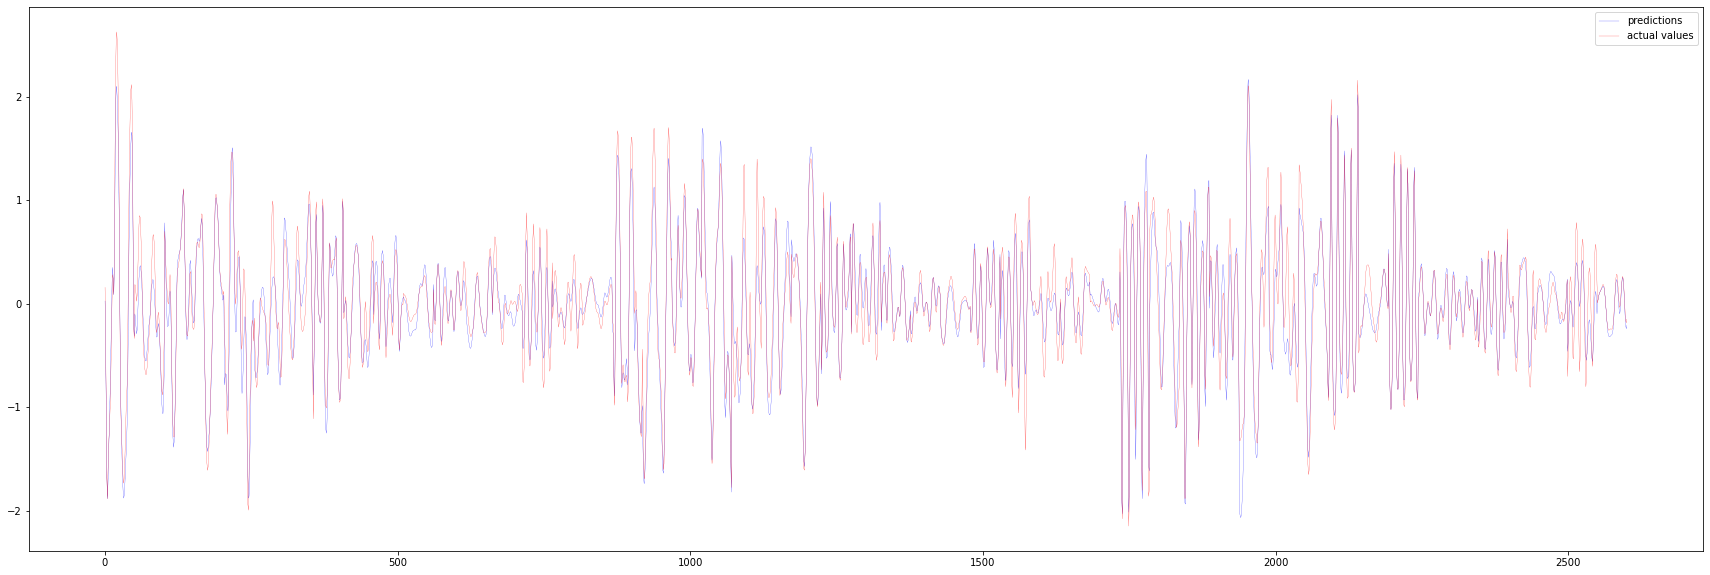

Forces MAE: 0.1245
Forces MSE: 0.0336


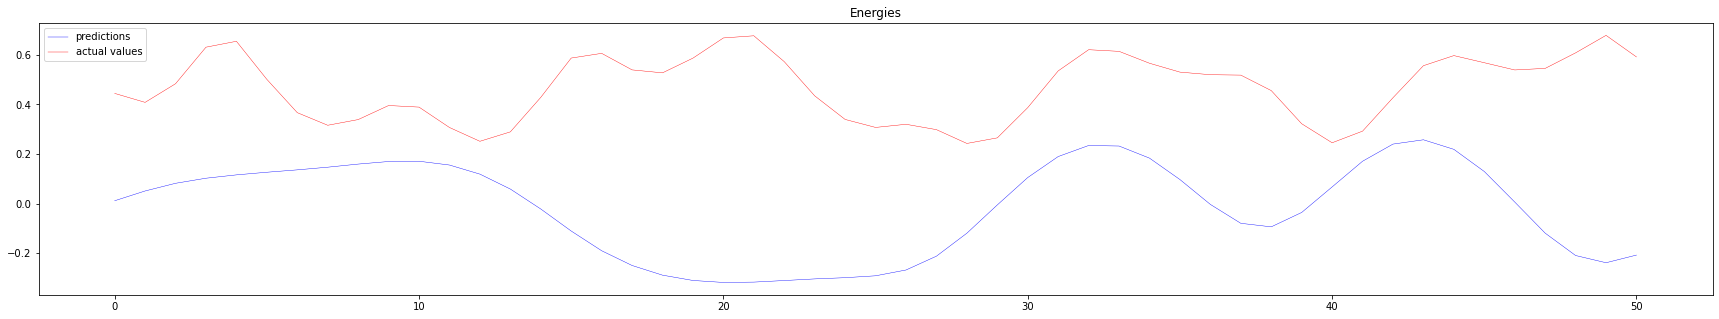

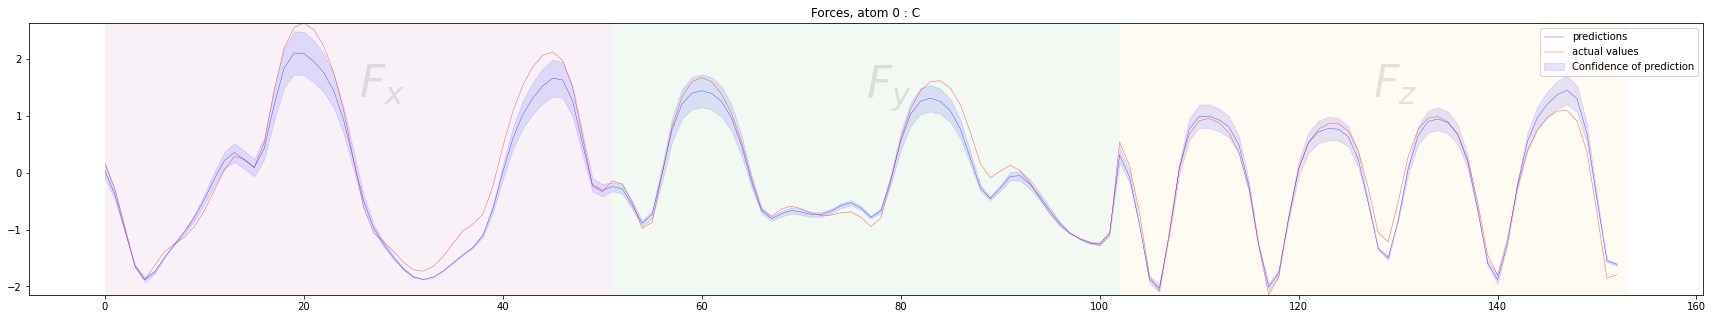

Forces MAE: 0.1642
Forces MSE: 0.0478
Cumulative uncertainty: 34.5856


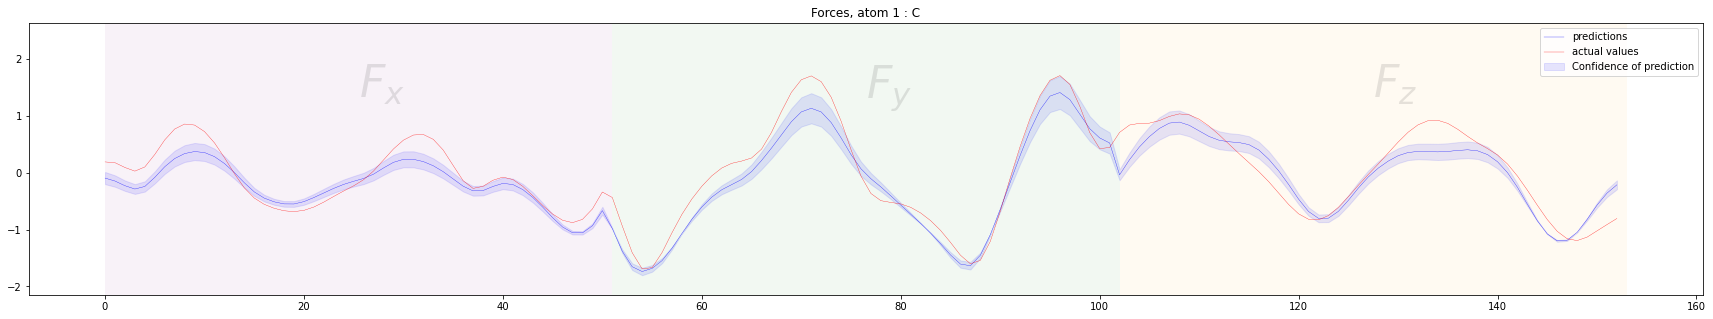

Forces MAE: 0.2378
Forces MSE: 0.0820
Cumulative uncertainty: 30.9334


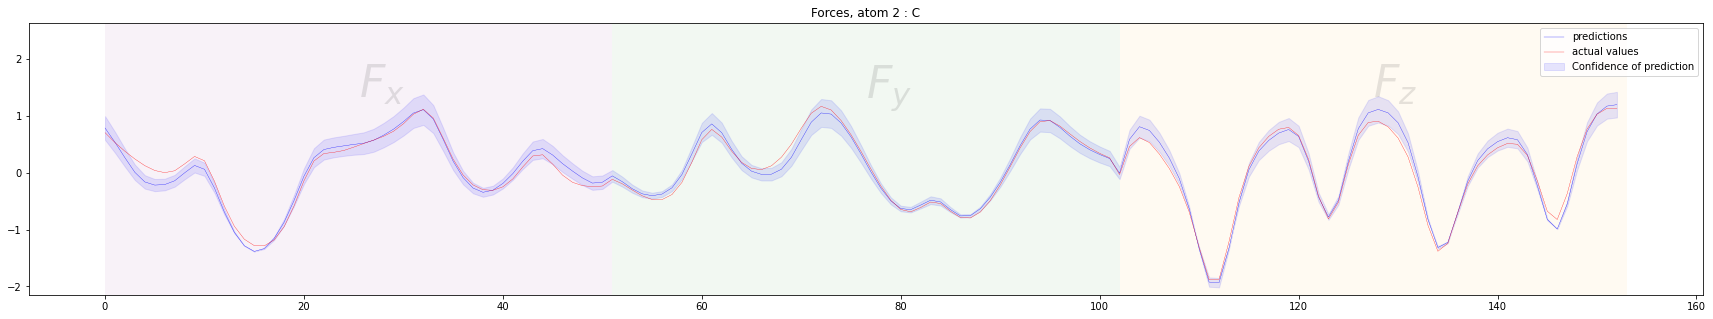

Forces MAE: 0.0850
Forces MSE: 0.0116
Cumulative uncertainty: 37.7013


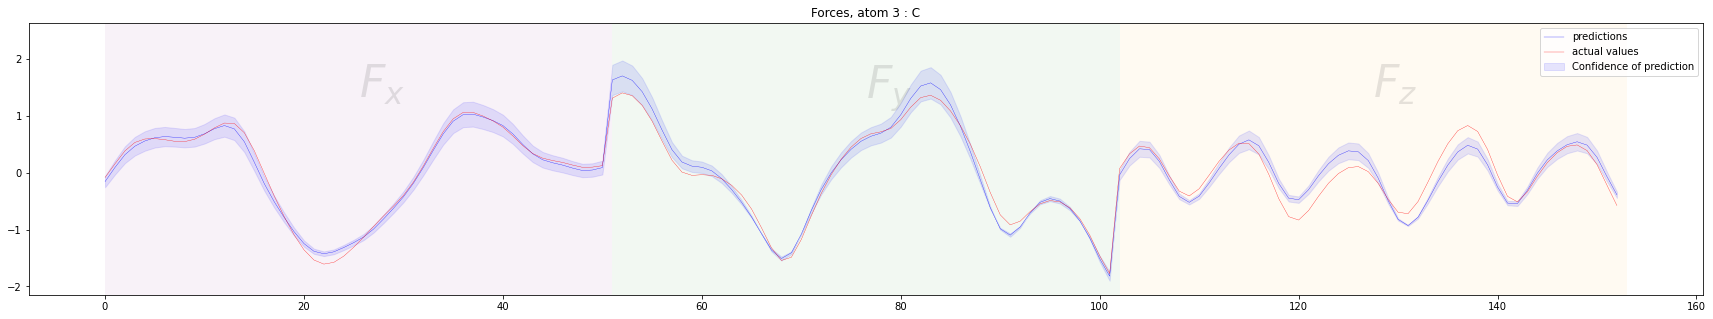

Forces MAE: 0.1157
Forces MSE: 0.0236
Cumulative uncertainty: 33.8505


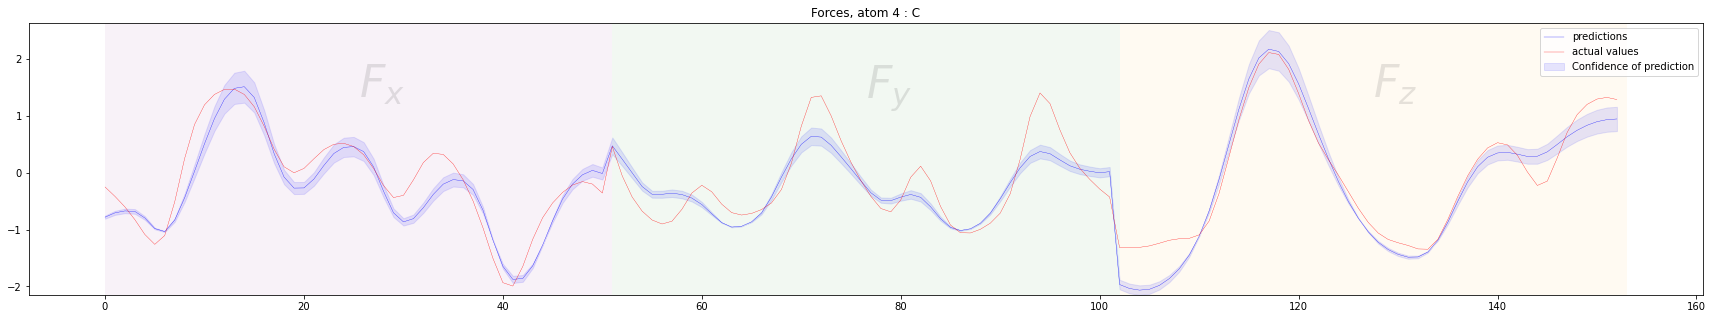

Forces MAE: 0.2758
Forces MSE: 0.1239
Cumulative uncertainty: 26.6525


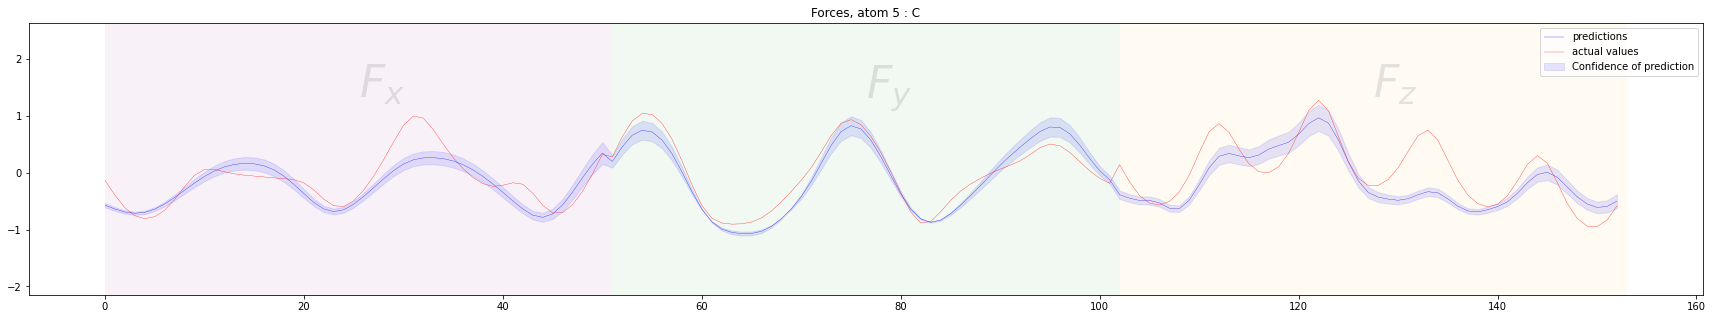

Forces MAE: 0.2313
Forces MSE: 0.0923
Cumulative uncertainty: 28.1072


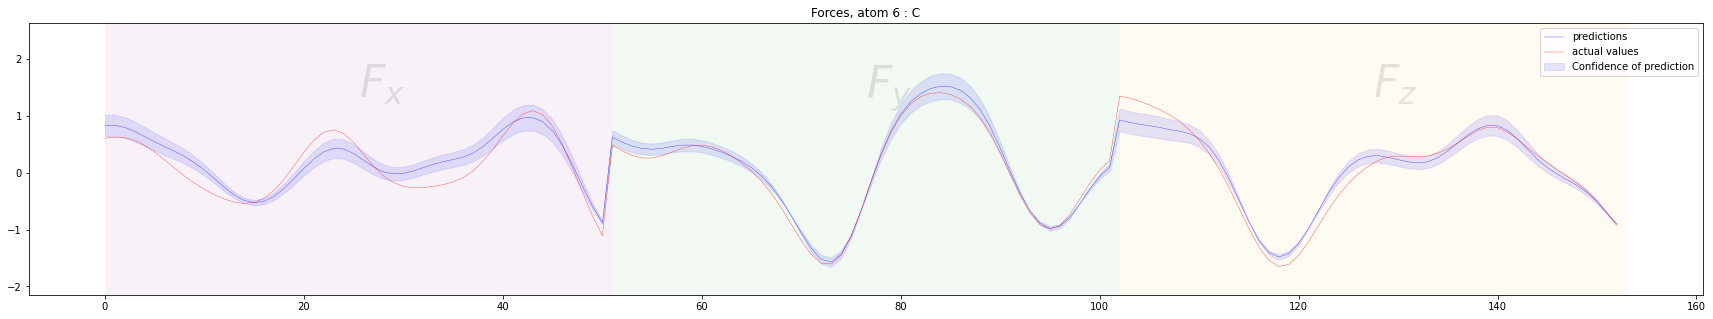

Forces MAE: 0.1380
Forces MSE: 0.0314
Cumulative uncertainty: 31.2920


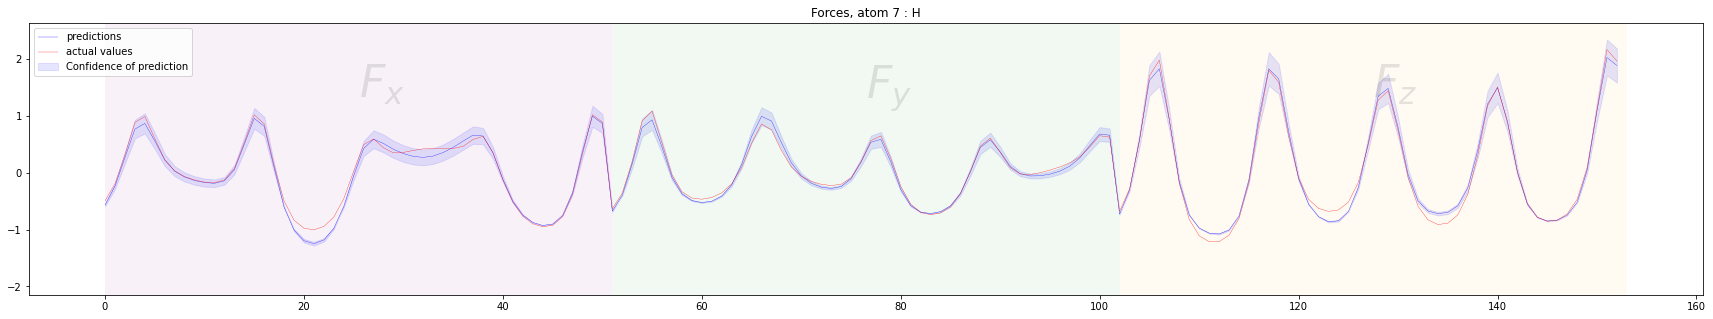

Forces MAE: 0.0627
Forces MSE: 0.0070
Cumulative uncertainty: 24.7011


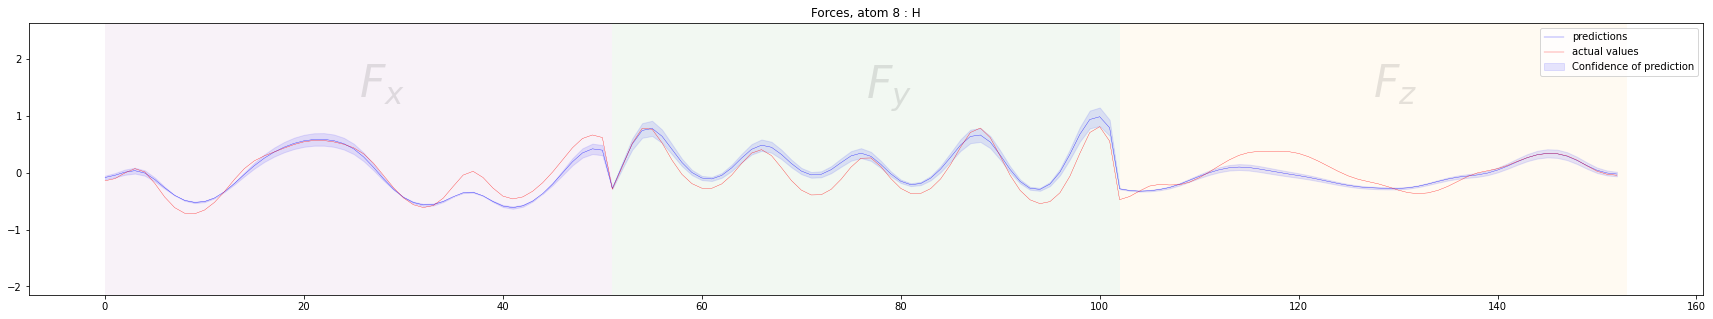

Forces MAE: 0.1306
Forces MSE: 0.0295
Cumulative uncertainty: 14.6198


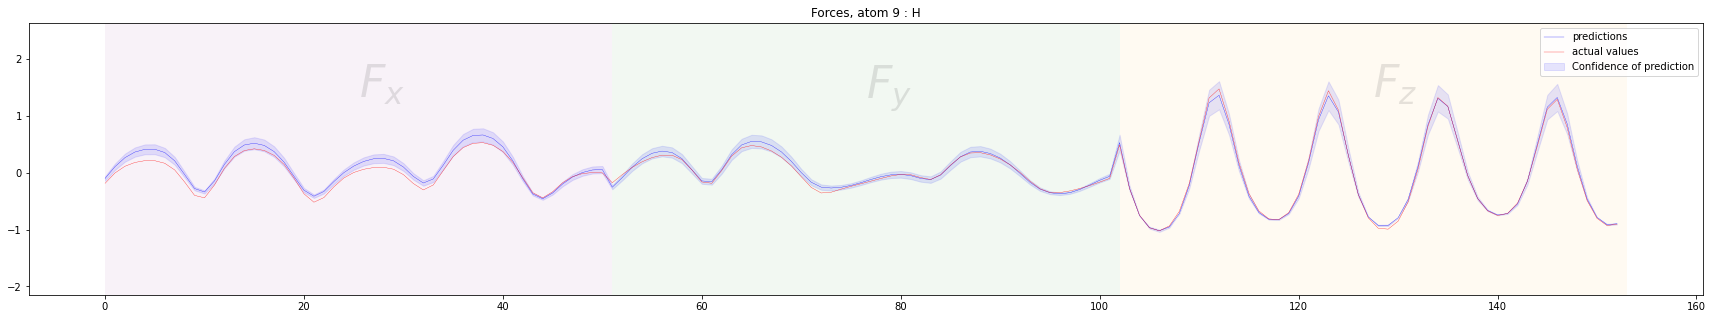

Forces MAE: 0.0543
Forces MSE: 0.0053
Cumulative uncertainty: 21.3452


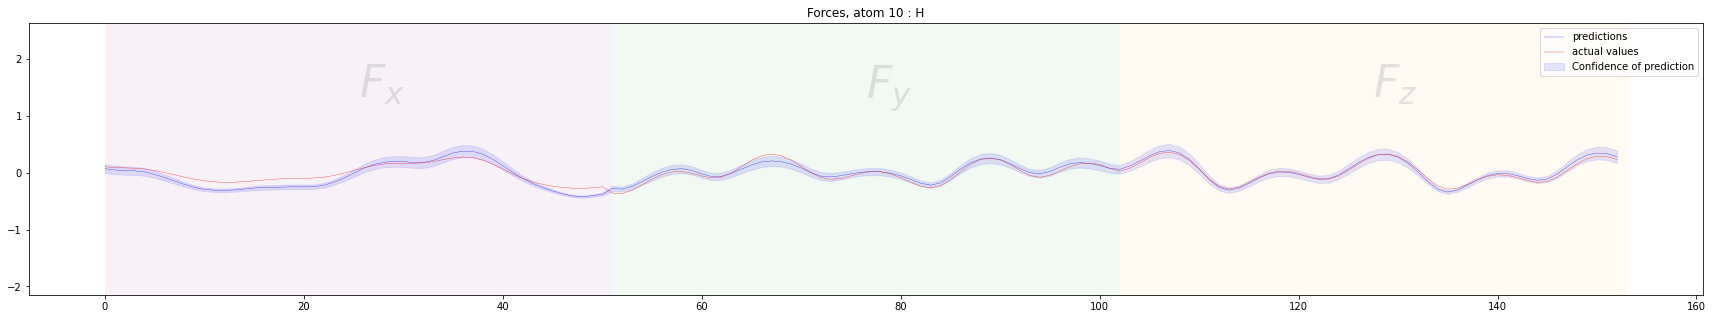

Forces MAE: 0.0526
Forces MSE: 0.0046
Cumulative uncertainty: 20.4060


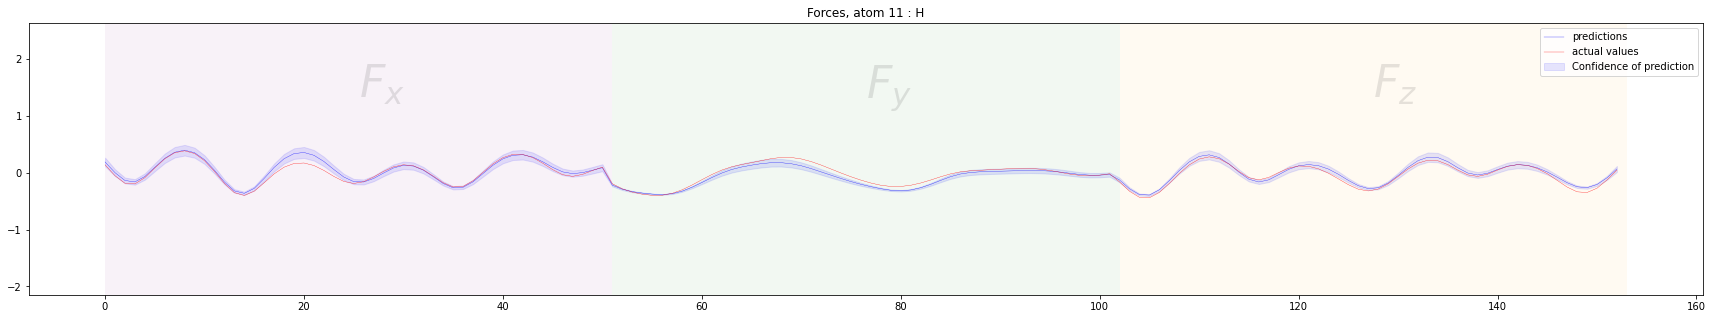

Forces MAE: 0.0436
Forces MSE: 0.0032
Cumulative uncertainty: 15.0909


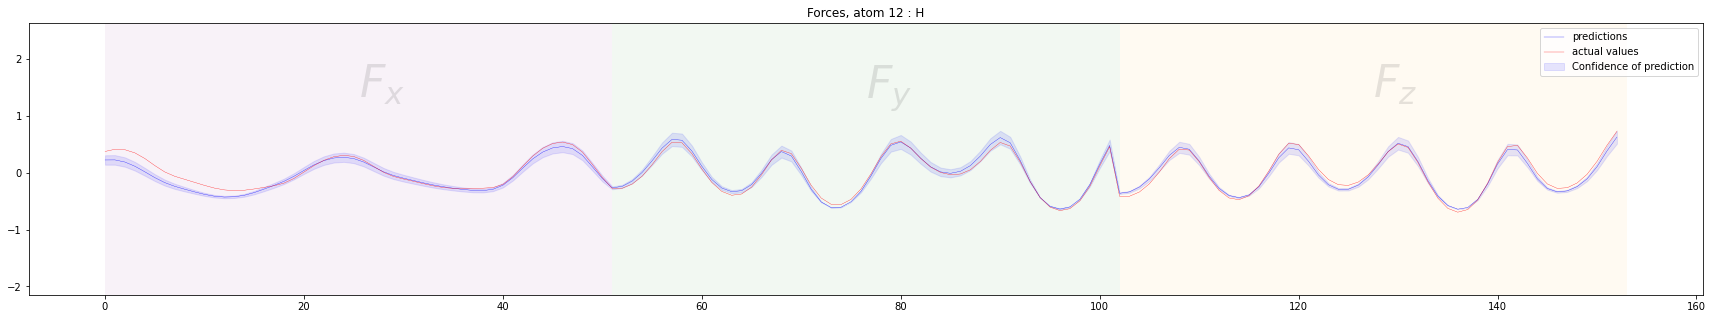

Forces MAE: 0.0553
Forces MSE: 0.0054
Cumulative uncertainty: 16.9986


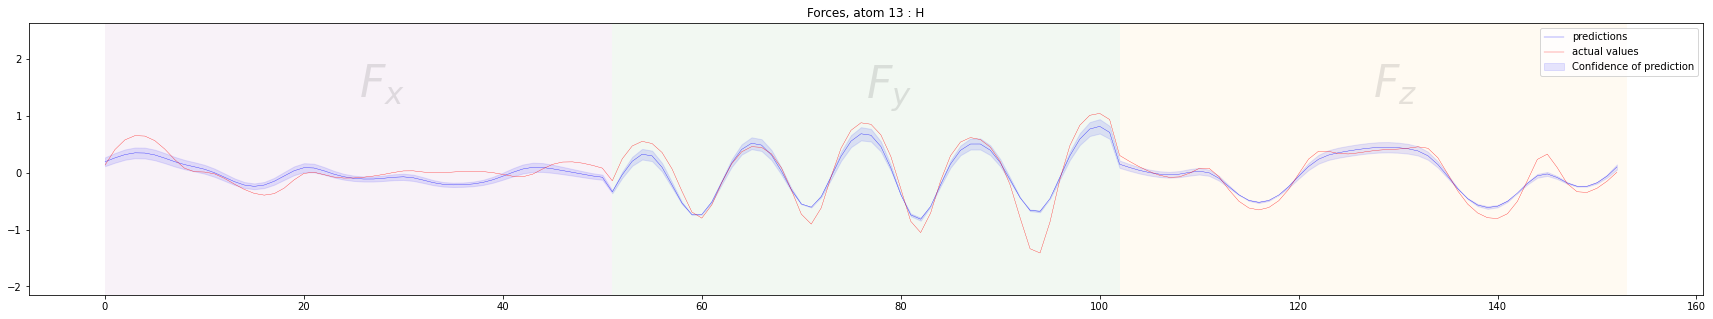

Forces MAE: 0.1303
Forces MSE: 0.0287
Cumulative uncertainty: 15.9251


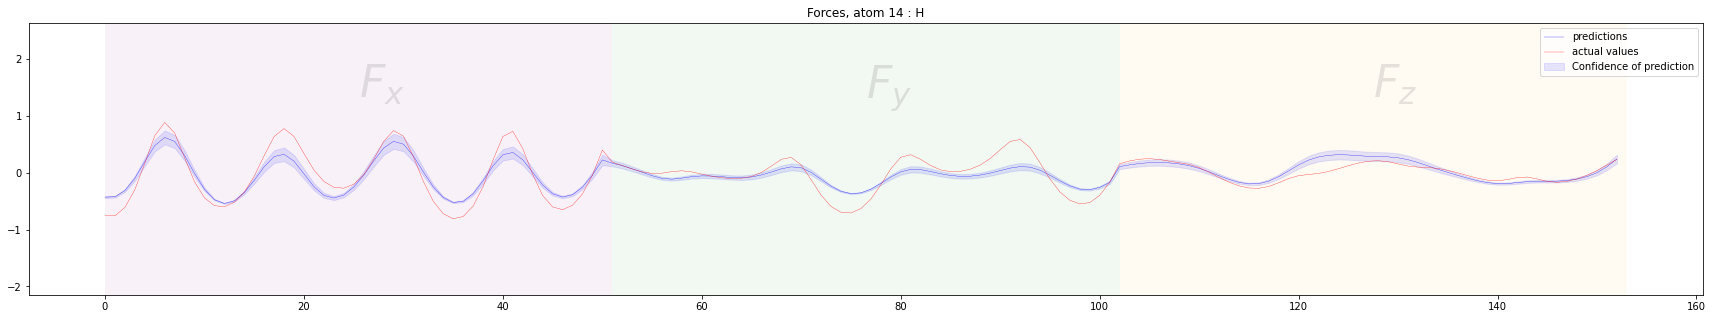

Forces MAE: 0.1367
Forces MSE: 0.0321
Cumulative uncertainty: 15.2206


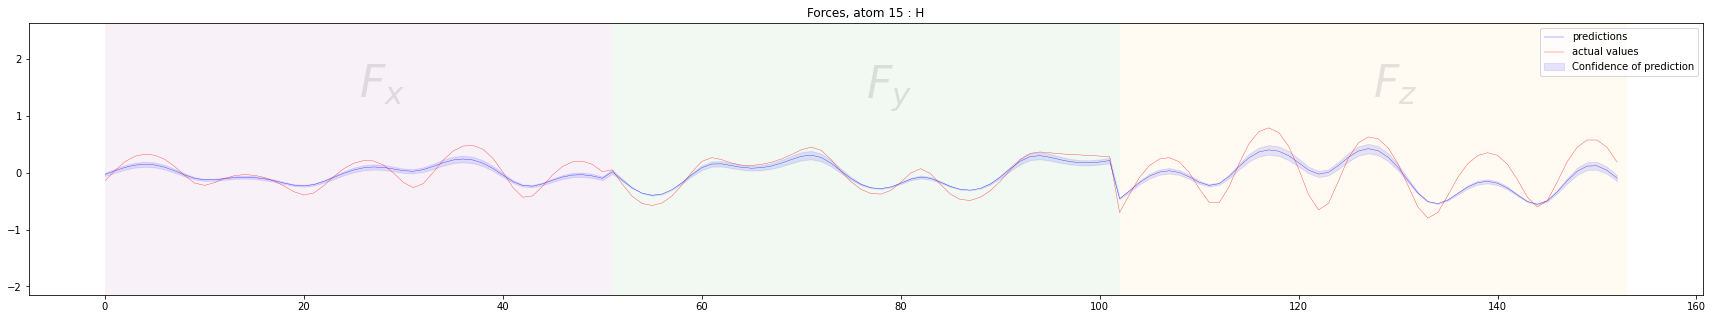

Forces MAE: 0.1544
Forces MSE: 0.0393
Cumulative uncertainty: 11.0574


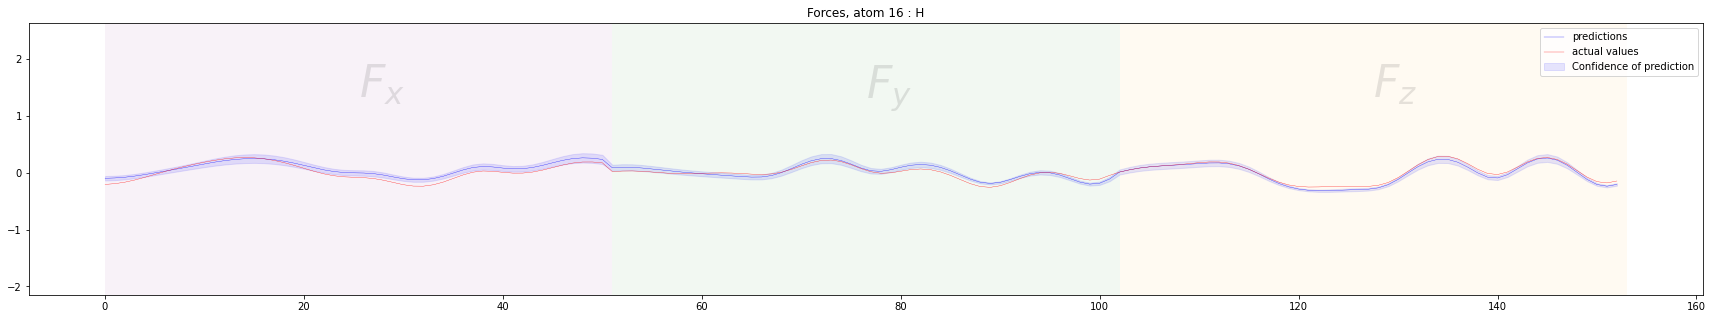

Forces MAE: 0.0478
Forces MSE: 0.0031
Cumulative uncertainty: 14.3623


In [62]:
from fande.predict import PredictorASE

test_X = fdm.test_X
test_DX = fdm.test_DX
test_E = fdm.test_E
test_F = fdm.test_F

model_e = None
trainer_e = None

# del predictor

predictor = PredictorASE(
            fdm,
            model_e,
            model_f,
            trainer_e,
            trainer_f,
            hparams,
            soap_params
)


predictor.predict_and_plot_forces()

### Testing ASE calc

In [87]:
%%time
from fande.ase import FandeCalc
from ase.build import molecule

from ase import io

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.INFO) # logging.ERROR to disable or INFO


logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)


# atoms = fdm.traj_test[10].copy()

# # atoms = molecule("CH3CH2OCH3")
# fande_calc = FandeCalc(predictor)

# # for a in traj: a.calc=fande_calc 
# atoms.calc = fande_calc

# print(atoms.get_potential_energy() )
# print( atoms.get_forces() - fdm.forces_test[10])


test_f = fdm.forces_test

ml_test_f = np.zeros_like(test_f)

for i, mol in enumerate(fdm.traj_test):
        atoms = mol.copy()
        fande_calc = FandeCalc(predictor)
        atoms.calc = fande_calc

        ml_test_f[i] = atoms.get_forces()

atom_ind = 4


# plt.plot( np.concatenate( (test_f[:,atom_ind,0], test_f[:,atom_ind,1], test_f[:,atom_ind,2]) ) )
# plt.plot( np.concatenate( (ml_test_f[:,atom_ind,0], ml_test_f[:,atom_ind,1], ml_test_f[:,atom_ind,2])  ) )

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() call

### Molecular Dynamics with Fande calculator

In [94]:
%%capture
from fande.ase import FandeCalc
from sdynamics import MDRunner
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR) # logging.ERROR to disable or INFO

# atoms = fdm.mol_traj[10].copy()
atoms = fdm.traj_train[250].copy()
atoms.calc = FandeCalc(predictor)

# print( atoms.get_forces() )
# print( atoms.get_potential_energy())

mdr = MDRunner(atoms, "../data/dump/ase/md_test.xyz", "../data/dump/ase/md_log.log")
mdr.run(time_step=0.05, num_steps=5_000)

In [95]:
from ase.visualize import view

traj_ml = io.read("../data/dump/asemd.traj", index=":")
view(traj_ml)

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>

Traceback (most recent call last):
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/matplotlib/pyplot.py", line 368, in show
    return _backend_mod.show(*args, **kwargs)
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py", line 41, in show
    display(
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on closed file.
Exception in Tk

### Prepare xtb md data

In [36]:
## Save Energies and forces for xtb_md

forces_xtb_md = np.zeros((len(traj_ml), 17, 3))
energies_xtb_md = np.zeros(len(traj_ml))


for i,mol in enumerate(traj_ml):
        forces_xtb_md[i] = traj_ml[i].get_forces()
        energies_xtb_md[i] = traj_ml[i].get_potential_energy()

np.save("../data/dump/forces_xtb_md.npy", forces_xtb_md)
np.save("../data/dump/energies_xtb_md.npy", energies_xtb_md)